### Analisis_Detector_Silicio

Caracterización de diodos de silicio. El proceso consiste en estimar el ancho e la zona de deplexión $w$, el voltaje de la zona de deplexión $V_{dep}$ y la concentración de dopaje effectiva $N_{eff}$ desde las mediciones CV del diodo.

El ancho de a zona de deplexión se define como

$$w = \sqrt{\frac{2\varepsilon V_{dep}}{e |N_{eff}|}}$$

donde $\varepsilon$ es la permitividad del material, $e$ es la carga del electrón y $N_{eff}$ el dopaje efectivo del material.

El voltaje de deplexión se estima con la fórmula

$$V_{dep}= \frac{n_2-n_1}{k_1-k_2}$$

donde $n$ y $k$ son el intercepto y la pendiente de la recta ajustada a las mediciones CV.

La concentración de dopaje efectiva se deriva de

$$|N_{eff}|= \frac{2}{A^2\varepsilon e} \frac{dV}{d(1/C^2)}$$

donde $\frac{dV}{d(1/C^2)}$ es la pendiente del ajuste lineal de la curva C2V.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [41]:
def CV(data,  A):#, v1, v2, v3, v4):
    
    eR = 11.9;     # Silicon relative dielectric constant
    e0 = 8.85e-14; # Permittivity of free space [F/cm]
    q0 = 1.6e-19;  # Electron electric charge [C]
    
    V = data[:,0]  # Capacitance-voltage measurements
    C = data[:,1]
    
    # Plotting input data
    
    plt.figure(figsize =(7,5))
    plt.plot(V,C, 'ob', fillstyle = 'none')
    plt.xlabel("V$_{bias}$ [V]", fontsize=15)
    plt.ylabel("C [F]", fontsize=15)
    plt.grid()
    plt.show()

    c = np.abs(C)
    v = np.abs(V)
    logC = np.log10(c)
    logV = np.log10(v)
    C2 = 1/c/c
    
    # Funcion de ajuste
    def loglin(x, a, b):
        return a + b*x
    
    logv1 = 2
    logv2 = 11
    logv3 = 19
    logv4 = 100
    N = 101   # fit points

    # Depletion voltage extraction
    
    # logClogV curve fitting
    
    initial_guess = [0, 0]
    pars1, pcov1 = curve_fit(loglin, logV[logv1:logv2], logC[logv1:logv2], p0=initial_guess)
    pars2, pcov2 = curve_fit(loglin, logV[logv3:logv4], logC[logv3:logv4], p0=initial_guess)

    xloglin1 = np.linspace(logV[logv1],logV[logv2],N)
    yloglin1 = loglin(logV[logv1:logv2], pars1[0], pars1[1])

    xloglin2 = np.linspace(0.8,2,N)
    yloglin2 = loglin(logV[logv3:logv4], pars2[0], pars2[1])

    # Fit parameters q = intercept, m = slope

    logq1 = pars1[0]
    logq2 = pars2[0]
    logm1 = pars1[1]
    logm2 = pars2[1]

    # Fit errors
    perr1 = np.sqrt(np.diag(pcov1))
    perr2= np.sqrt(np.diag(pcov2))

    elogq1 = perr1[0]
    elogq2 = perr2[0]
    elogm1 = perr1[1]
    elogm2 = perr2[1]

    chi1 = np.sum(((yloglin1-logC[logv1:logv2])/np.std(logV[logv1:logv2]))**2)
    chi2 = np.sum(((yloglin2-logC[logv3:logv4])/np.std(logV[logv3:logv4]))**2)
    
    
    logvdep = (logq1-logq2)/(logm2-logm1)
    vdepl = pow(10., logvdep)  # depletion voltage

    Deltam = np.sqrt(elogm1**2 + elogm2**2)
    Deltaq = np.sqrt(elogq1**2 + elogq2**2)

    evdepl = np.sqrt(pow(Deltaq,2.)/pow((logm2-logm1),2.) + pow(Deltam,2.)*pow((logq1-logq2),2.)/pow((logm2-logm1),2.))
    evdepl = pow(10., evdepl)
    
    # Plotting
    
    plt.figure(figsize =(7,5))
    plt.plot(logV,logC, 'ob', fillstyle = 'none')
    plt.plot(logV[logv1:logv2],yloglin1, 'r')
    plt.plot(logV[logv3:logv4],yloglin2, 'b')
    plt.xlabel("log$_{10}$ [V$_{bias}$/V]", fontsize=15)
    plt.ylabel("log$_{10}$ [C/F]", fontsize=15)
    plt.xlim([0,2])
    plt.grid()
    plt.show()
    
    # Effective doping concentration estimation
    
    # C2V curve fitting
    
    initial_guess = [0, 0]
    pars3, pcov3 = curve_fit(loglin, V[logv1:logv2], C2[logv1:logv2]/1e23, p0=initial_guess)

    xloglin3 = np.linspace(V[logv1],V[logv2],N)
    yloglin3 = loglin(V[logv1:logv2], pars3[0], pars3[1])*1e23

    # Fit parameters

    Vder = pars3[0]*1e23
    C2der = pars3[1]*1e23

    # Fit errors
    perr3 = np.sqrt(np.diag(pcov3))

    eVder = perr3[0]*1e23
    eC2der = perr3[1]*1e23

    chi3 = np.sum(((yloglin3-C2[logv1:logv2])/np.std(V[logv1:logv2]))**2)
    
    neff = 2./A/A/q0/eR/e0/C2der
    eneff = 2./A/A/q0/eR/e0/C2der/C2der*eC2der

    w = pow(2.*eR*e0*vdepl/q0/neff,0.5)

    ewA = 2*eR*e0/q0
    ewA = pow(ewA,0.5)

    ewNeff = 0.5*ewA*pow(vdepl,0.5)*pow(neff,-1.5)*eneff
    ewV = 0.5*ewA*pow(vdepl,-0.5)*pow(neff,-0.5)*evdepl

    ew = np.sqrt(ewNeff*ewNeff+ewV*ewV)
    
    plt.figure(figsize =(7,5))
    plt.plot(V,C2, 'ob', fillstyle = 'none')
    plt.plot(V[logv1:logv2],yloglin3, 'r')
    plt.xlabel("V $_{bias}$[V]", fontsize=15)
    plt.ylabel("C$^2$ [F$^2$]", fontsize=15)
    plt.grid()
    plt.show()
    
    # Printing resulta
    
    print ("*********************************")
    print ("Chi2      = %f" % chi1)
    print ("p0        = %f +/- %f" % (logq1, elogq1))
    print ("p1        = %f +/- %f\n" % (logm1, elogm1))

    print ("*********************************")
    print ("Chi2      = %e" % chi2)
    print ("p0        = %f +/- %f" % (logq2, elogq2))
    print ("p1        = %f +/- %f\n" % (logm2, elogm2))

    print ("*********************************")
    print ("Chi2      = %e" % chi3)
    print ("p0        = %e +/- %e" % (Vder, eVder))
    print ("p1        = %e +/- %e\n" % (C2der, eC2der))

    print ("v1 = %f V" % V[logv1])
    print ("v2 = %f V" % V[logv2])
    print ("v3 = %f V" % V[logv3])
    print ("v4 = %f V" % V[logv4])

    print ("vdepl = %f V" % vdepl)
    print ("evdepl = %f V" % evdepl)

    print ("neff = %e 1./cm^3" % neff)
    print ("eneff = %e 1./cm^3" % eneff)
    print ("w = %f um" % (w*1e+4))
    print ("ew = %f um" % (ew*1e+4))

In [32]:
CV_data = np.loadtxt('CV_10kHz.txt')
V = CV_data[:,0]
C = CV_data[:,1]

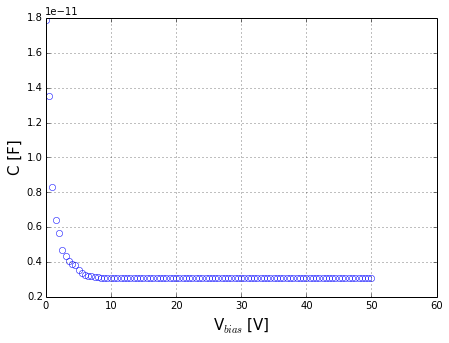

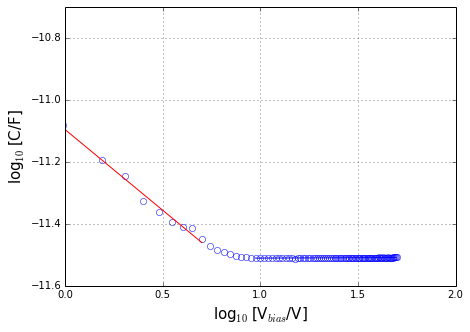

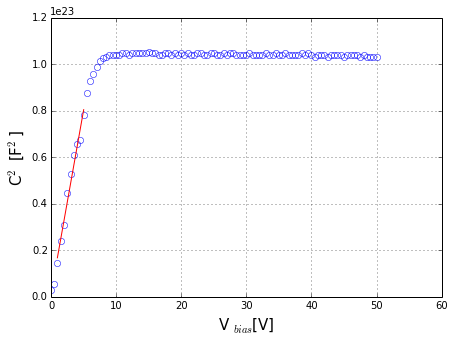

*********************************
Chi2      = 0.034866
p0        = -11.095447 +/- 0.011347
p1        = -0.520365 +/- 0.023525

*********************************
Chi2      = 1.201541e-03
p0        = -11.512260 +/- 0.000625
p1        = 0.002267 +/- 0.000433

*********************************
Chi2      = 5.226453e+43
p0        = 1.466408e+21 +/- 2.980421e+21
p1        = 1.576831e+22 +/- 9.108217e+20

v1 = 0.975400 V
v2 = 5.500200 V
v3 = 9.450000 V
v4 = 50.001400 V
vdepl = 6.273741 V
evdepl = 1.068368 V
neff = 9.292867e+10 1./cm^3
eneff = 5.367822e+09 1./cm^3
w = 298.118253 um
ew = 26.804102 um


In [42]:
CV(CV_data,  9e-2)